In [2]:
import cv2
import numpy as np
import pandas as pd
import os 
import torch
import torch.nn.functional as F
import torchvision

from tqdm import tqdm

In [3]:
data_dir = '../osic-pulmonary-fibrosis-progression'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import random

# Input: List of patient_id
# Output: Tuple of (train_patient_ids, val_patient_ids)
# train_ratio: Ratio of training set
def train_val_split(patients: pd.DataFrame, train_ratio: float = 0.8) -> (pd.DataFrame, pd.DataFrame):
  patient_ids = patients['Patient'].unique()
  random.shuffle(patient_ids)

  train_patients = patients[patients['Patient'].isin(patient_ids[:int(len(patient_ids) * train_ratio)])]
  val_patients = patients[patients['Patient'].isin(patient_ids[int(len(patient_ids) * train_ratio):])]

  return train_patients, val_patients

In [5]:
# Prepare train and val data
train_patients = pd.read_csv(data_dir + '/train.csv')
test_patients = pd.read_csv(data_dir + '/test.csv')

# Remove row in train data if patient_id is in test_patient_ids
train_patients = train_patients[~train_patients['Patient'].isin(test_patients)]

train_patients, val_patients = train_val_split(train_patients)

# Sort df by patient and then by 'Weeks'
train_patients = train_patients.sort_values(by=['Patient', 'Weeks'])

# Group by patient and get the first FVC value
patient_id_to_initial_FVC = train_patients.groupby('Patient')['FVC'].first().to_dict()

In [6]:
len(train_patients)

1232

In [7]:
# Edge detection using Sobel operator
def extract_edge(image_array: np.ndarray, batching: bool = False) -> list[np.ndarray]:
  if device == torch.device('cuda'):
    batch = torch.tensor(image_array, dtype=torch.float32, device=device)
    # Convert to batch tensor (N, 1, H, W)
    if not batching:
      batch = batch.unsqueeze(0).unsqueeze(0)
    else:
      batch = batch.unsqueeze(1)

    # Define Sobel kernels
    sobel_x = torch.tensor([
      [-1, 0, 1],
      [-2, 0, 2],
      [-1, 0, 1]
    ], dtype=torch.float32, device=device).view(1, 1, 3, 3)
    
    sobel_y = torch.tensor([
      [-1, -2, -1],
      [ 0,  0,  0],
      [ 1,  2,  1]
    ], dtype=torch.float32, device=device).view(1, 1, 3, 3)
    
    # Apply Sobel filters to entire batch
    edges_x = F.conv2d(batch, sobel_x, padding=1)
    edges_y = F.conv2d(batch, sobel_y, padding=1)
    
    # Compute magnitude
    edges = 0.5 * torch.abs(edges_x) + 0.5 * torch.abs(edges_y)
    
    # Convert back to list of numpy arrays
    edges = edges.cpu().numpy()
    if not batching:
      edges = edges[0, 0]
    else:
      edges = edges[:, 0]

    del batch, edges_x, edges_y
    
    return edges
    
  edgesX = cv2.Sobel(image_array, cv2.CV_64F, 1, 0, ksize=3)
  edgesY = cv2.Sobel(image_array, cv2.CV_64F, 0, 1, ksize=3)
  absEdgesX = cv2.convertScaleAbs(edgesX)
  absEdgesY = cv2.convertScaleAbs(edgesY)
  edges = cv2.addWeighted(absEdgesX, 0.5, absEdgesY, 0.5, 0)
  return edges

In [8]:
def extract_corner(image_array: np.ndarray, block_size=2, ksize=3, k=0.04, batching: bool = False) -> list[np.ndarray]:
  if device == torch.device('cuda'):
    batch = torch.tensor(image_array, dtype=torch.float32, device=device)
    
    # Convert to batch tensor (N, 1, H, W)
    if not batching:
      batch = batch.unsqueeze(0).unsqueeze(0)
    else:
      batch = batch.unsqueeze(1)
    
    # Sobel kernels
    sobel_x = torch.tensor([
      [-1, 0, 1],
      [-2, 0, 2],
      [-1, 0, 1]
    ], dtype=torch.float32, device=device).view(1, 1, ksize, ksize)
    
    sobel_y = torch.tensor([
      [-1, -2, -1],
      [ 0,  0,  0],
      [ 1,  2,  1]
    ], dtype=torch.float32, device=device).view(1, 1, ksize, ksize)
    
    # Compute gradients for entire batch
    Ix = F.conv2d(batch, sobel_x, padding=1)
    Iy = F.conv2d(batch, sobel_y, padding=1)
    
    # Derivative products
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    # Gaussian kernel
    sigma = block_size / 2.0
    kernel_size = block_size * 2 + 1
    x = torch.arange(kernel_size, dtype=torch.float32, device=device) - kernel_size // 2
    gaussian_1d = torch.exp(-x ** 2 / (2 * sigma ** 2))
    gaussian_1d = gaussian_1d / gaussian_1d.sum()
    gaussian_2d = gaussian_1d.view(-1, 1) * gaussian_1d.view(1, -1)
    gaussian_2d = gaussian_2d.view(1, 1, kernel_size, kernel_size)
    
    # Apply Gaussian weighting
    padding = kernel_size // 2
    Sxx = F.conv2d(Ixx, gaussian_2d, padding=padding)
    Syy = F.conv2d(Iyy, gaussian_2d, padding=padding)
    Sxy = F.conv2d(Ixy, gaussian_2d, padding=padding)
    
    # Harris response for entire batch
    det = Sxx * Syy - Sxy * Sxy
    trace = Sxx + Syy
    harris_response = det - k * (trace * trace)
    
    # Apply threshold per image
    corners_list = []
    for i in range(harris_response.shape[0]):
      response = harris_response[i, 0]
      threshold = 0.05 * response.max()
      corners = response > threshold
      corners = corners.cpu().numpy().astype(np.float32)
      corners_list.append(corners)
    corners_list = np.array(corners_list)

    del batch, harris_response, Sxx, Syy, Sxy, Ixx, Iyy, Ixy, Ix, Iy
    if not batching:
      return corners_list[0]
    else:
      return corners_list
  
  # Apply cornerHarris
  score = cv2.cornerHarris(image_array, block_size, ksize, k)
  # 0.05 is a threshold to determine if a corner is valid
  corners = score > 0.05 * score.max()

  # Could consider returning original score without thresholding
  return corners


In [20]:
def extract_blob(image_array, batching: bool = False):
  if device == torch.device('cuda'):
    batch = torch.tensor(image_array, dtype=torch.float32, device=device)
    
    # Convert to batch tensor (N, 1, H, W)
    if not batching:
      batch = batch.unsqueeze(0).unsqueeze(0)
    else:
      batch = batch.unsqueeze(1)

    # Apply blurs to entire batch
    blurred1 = torchvision.transforms.functional.gaussian_blur(batch, kernel_size=(5, 5), sigma=(0.8, 0.8))
    blurred2 = torchvision.transforms.functional.gaussian_blur(batch, kernel_size=(11, 11), sigma=(0.8, 0.8))
    
    # Compute DoG for entire batch
    dog = blurred1 - blurred2
    
    # Normalize each image separately
    results = []
    for i in range(dog.shape[0]):
      dog_single = dog[i, 0]
      dog_min = dog_single.min()
      dog_max = dog_single.max()
      dog_normalized = (dog_single - dog_min) / (dog_max - dog_min + 1e-8) * 255
      results.append(dog_normalized.cpu().numpy())
    
    del batch, blurred1, blurred2, dog, dog_single, dog_min, dog_max, dog_normalized
    results = np.array(results)
    if not batching:
      return results[0]
    else:
      return results

  # Use DoG (Difference of Gaussian) to detect blobs
  # First, apply GaussianBlur to the image
  blurred1 = cv2.GaussianBlur(image_array, (5, 5), 0.8)
  blurred2 = cv2.GaussianBlur(image_array, (11, 11), 1.8)

  # Then, compute the difference between the blurred image and the original image
  dog = cv2.subtract(blurred1, blurred2)

  # minmax normalize the result to enhance contrast
  dog = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX)

  return dog

In [10]:
def extract_local_binary_pattern(image_array, batching: bool = False):
  if device == torch.device('cuda'):
    image = torch.tensor(image_array, dtype=torch.float32, device=device)
    
    # Convert to batch tensor (N, 1, H, W)
    if not batching:
      image = image.unsqueeze(0).unsqueeze(0)
    else:
      image = image.unsqueeze(1)

    # Create kernels for extracting each neighbor
    neighbor_kernels = []
    positions = [
      (0, 0), (0, 1), (0, 2),  # Top row
      (1, 2),                   # Right
      (2, 2), (2, 1), (2, 0),  # Bottom row
      (1, 0)                    # Left
    ]
    
    for i, (row, col) in enumerate(positions):
      kernel = torch.zeros(1, 1, 3, 3, device=device)
      kernel[0, 0, row, col] = 1.0
      neighbor_kernels.append(kernel)
    
    # Extract center pixel value
    center_kernel = torch.zeros(1, 1, 3, 3, device=device)
    center_kernel[0, 0, 1, 1] = 1.0
    center = F.conv2d(image, center_kernel, padding=1)
  
    # Initialize LBP
    lbp_image = torch.zeros_like(center)
    
    # Compare each neighbor
    for k, kernel in enumerate(neighbor_kernels):
      neighbor = F.conv2d(image, kernel, padding=1)
      comparison = (neighbor >= center).float()
      lbp_image += comparison * (2 ** k)
    
    result = lbp_image.cpu().numpy()

    del image, center, center_kernel, neighbor_kernels, neighbor, comparison, lbp_image

    if not batching:
      return result[0][0]
    else:
      return result.squeeze(1)

  # Use CPU otherwise
  # Get image dimensions
  height, width = image_array.shape

  # Initialize LBP image
  lbp_image = np.zeros_like(image_array)

  # Define 8-neighborhood offsets (8-connected)
  offsets = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]

  # Apply LBP to each pixel (excluding border pixels)
  for i in range(1, height - 1):
    for j in range(1, width - 1):
      center_pixel = image_array[i, j]
      binary_pattern = 0

      # Compare center pixel with 8 neighbors
      for k, (di, dj) in enumerate(offsets):
        neighbor_pixel = image_array[i + di, j + dj]
        if neighbor_pixel >= center_pixel:
          binary_pattern |= (1 << k)

      lbp_image[i, j] = binary_pattern

  return lbp_image


In [11]:
def extract_gabor_feature(image_array, batching: bool = False):
  # Define Gabor filter parameters
  orientations = [0, 45, 90, 135]  # 4 orientations in degrees
  frequencies = [0.1, 0.2, 0.3]   # 3 different frequencies
  sigma = 2.0  # Standard deviation of Gaussian envelope
  gamma = 0.5  # Spatial aspect ratio

  # Initialize feature maps
  gabor_features = []

  if device == torch.device('cuda') and not batching:
    image_array = torch.tensor(image_array, dtype=torch.float32, device=device)
    image_array = image_array.unsqueeze(0).unsqueeze(0)
  elif device == torch.device('cuda'):
    image_array = torch.tensor(image_array, dtype=torch.float32, device=device)
    image_array = image_array.unsqueeze(1)

  # Apply Gabor filters with different orientations and frequencies
  for orientation in orientations:
    for frequency in frequencies:
      # Convert orientation to radians
      theta = np.radians(orientation)

      # Create Gabor kernel
      kernel = cv2.getGaborKernel(
        ksize=(15, 15),  # Kernel size
        sigma=sigma,
        theta=theta,
        lambd=1.0/frequency,  # Wavelength
        gamma=gamma,
        psi=0,  # Phase offset
        ktype=cv2.CV_32F
      )

      if device == torch.device('cuda'):
        kernel = torch.tensor(kernel, dtype=torch.float32, device=device)
        kernel = kernel.unsqueeze(0).unsqueeze(0)
        filtered = F.conv2d(image_array, kernel, padding=7)
        magnitude = torch.abs(filtered)
        
        min_val = magnitude.min()
        max_val = magnitude.max()

        # Apply the min-max normalization formula
        normalized_data = (magnitude - min_val) / (max_val - min_val)

        gabor_feature = normalized_data.cpu().numpy()
        del magnitude, min_val, max_val, normalized_data, filtered
        gabor_features.append(gabor_feature)

      else:
        # Apply filter
        filtered = cv2.filter2D(image_array, cv2.CV_32F, kernel)

        # Take magnitude of response
        magnitude = np.abs(filtered)

        # Normalize to 0-255 range
        magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

        gabor_features.append(magnitude)

  # Combine all Gabor responses (mean of all filter responses)
  combined_gabor = np.mean(gabor_features, axis=0)

  if not batching:
    return combined_gabor[0][0]
  else:
    return combined_gabor.squeeze(1)


In [12]:
import pydicom

# Read indivudal scans from DICOM files
def read_dicom(path):
  dicom = pydicom.dcmread(path)
  # Convert image to float32
  image_array = np.float32(dicom.pixel_array)
  return image_array

In [13]:
def organize_dicom():
    # Reorganize numbering for dicom files in each patient folder
    for patient_id in os.listdir(f'{data_dir}/train'):
        # Rename each file into according order
        existing_files = os.listdir(f'{data_dir}/train/{patient_id}/')
        existing_files.sort(key=lambda x: int(x.split('.')[0]))
        for i, file_name in enumerate(existing_files):
            os.rename(f'{data_dir}/train/{patient_id}/{file_name}', f'{data_dir}/train/{patient_id}/{i+1}.dcm')

organize_dicom()

In [16]:
import os
import pandas as pd
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "preprocessing")))
from preprocess import preprocess_dicom

tabular = pd.read_csv(f'{data_dir}/train.csv')
patient_ids = tabular['Patient'].unique()

def get_patient_scans_path(patient_id):
  dir_size = len(os.listdir(f'{data_dir}/train/{patient_id}/'))
  return [f'{data_dir}/train/{patient_id}/{i}.dcm' for i in range(1, dir_size + 1)]

def load_patient_scans(patient_id):
  scan_paths = get_patient_scans_path(patient_id)
  dcms = []
  for scan_path in scan_paths:
    try:
      dcm = pydicom.dcmread(scan_path)
      # Make sure pixel_array is readable
      pixel_array = dcm.pixel_array
      dcms.append(dcm)
    except Exception as e:
      print(f'Patient {patient_id} have undecodable pixel_array. Error: {e}')
      return np.array([], dtype=np.float32)
  preprocessed_scans = preprocess_dicom(patient_id, dcms)
  patient_scans = np.array(preprocessed_scans, dtype=np.float32)
  return patient_scans

Using device: cuda


In [17]:
def extract_features(scan, batching: bool = False):
  features = []
  with torch.no_grad():
    features.append(extract_edge(scan, batching=batching))
    features.append(extract_corner(scan, batching=batching))
    features.append(extract_blob(scan, batching=batching))
    features.append(extract_local_binary_pattern(scan, batching=batching))
    features.append(extract_gabor_feature(scan, batching=batching))
  return np.array(features)

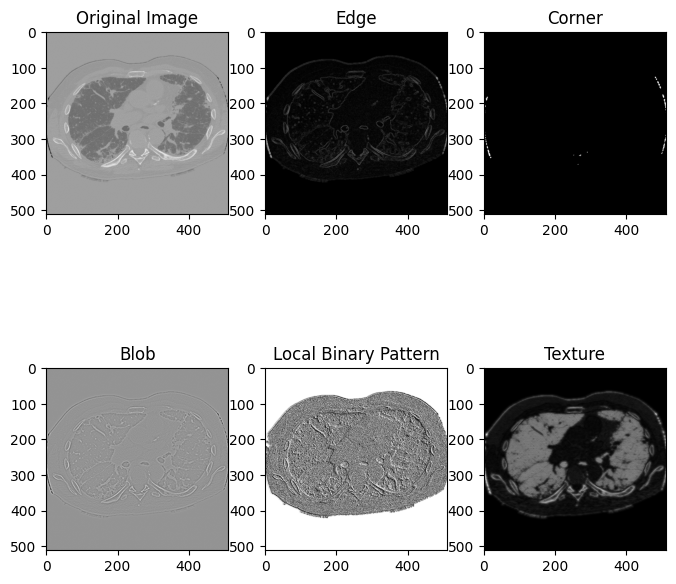

In [21]:
import matplotlib.pyplot as plt

patient_id = train_patients.iloc[0].Patient
scans = load_patient_scans(patient_id)
features = extract_features(scans[15])
feature_idx_to_name = ["Original Image", "Edge", "Corner", "Blob", "Local Binary Pattern", "Texture"]

# Compare original image to features
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
axs[0][0].imshow(scans[15], cmap='gray')
axs[0][0].set_title('Original Image')
for row in range(2):
  for col in range(3):
    if row == 0 and col == 0:
      continue
    axs[row][col].imshow(features[row * 3 + col - 1], cmap='gray')
    axs[row][col].set_title(feature_idx_to_name[row * 3 + col])
plt.show()

### Approach 1: Use random forest to regress on individual scan and individual features

In [16]:
x_train = []
y_train = []
train_data = dict()

no_scan_patient_ids = set()

for row in train_patients.itertuples():
  patient_id = row.Patient
  if patient_id in no_scan_patient_ids:
    continue
  try:
    scan_paths = get_patient_scans_path(patient_id)
  except Exception as e:
    if patient_id not in no_scan_patient_ids:
      no_scan_patient_ids.add(patient_id)
      print(e)
    continue

  for i in range(len(scan_paths)):
    train_data[patient_id] = {
      'patient_id': patient_id,
      'scan_index': i,
      'scan_positional_ratio': round((i+1) / len(scan_paths), 4),
      'initial_FVC': patient_id_to_initial_FVC[patient_id],
      'week': row.Weeks,
      'FVC': row.FVC
    }
    
    x_train.append({
      'patient_id': patient_id,
      'scan_index': i,
      'scan_positional_ratio': round((i+1) / len(scan_paths), 4),
      'initial_FVC': patient_id_to_initial_FVC[patient_id],
      'week': row.Weeks
    })
    y_train.append(row.FVC)

x_train = pd.DataFrame(x_train)
y_train = pd.Series(y_train)

In [18]:
def preprocess_scans():
    patient_ids = x_train['patient_id']
    scan_indexs = x_train['scan_index']

    unique_patient_ids = x_train['patient_id'].unique()

    scans = dict()

    for i in tqdm(range(len(unique_patient_ids))):
        patient_id = unique_patient_ids[i]
        scan = load_patient_scans(patient_id)
        if scan.any():
            scans[patient_id] = scan
    
    if not os.path.exists(f'{data_dir}/preprocessed_scans'):
        os.makedirs(f'{data_dir}/preprocessed_scans')
    for patient_id in scans:
        np.save(f'{data_dir}/preprocessed_scans/{patient_id}.npy', scans[patient_id])

    return scans
preprocess_scans()

  0%|          | 0/140 [00:00<?, ?it/s]

 12%|█▏        | 17/140 [00:52<06:27,  3.15s/it]

Patient ID00052637202186188008618 have undecodable pixel_array. Error: Unable to decompress 'JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])' pixel data because all plugins are missing dependencies:
	gdcm - requires gdcm>=3.0.10
	pylibjpeg - requires pylibjpeg>=2.0 and pylibjpeg-libjpeg>=2.1


100%|██████████| 140/140 [07:09<00:00,  3.07s/it]


{'ID00007637202177411956430': array([[[-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         ...,
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.]],
 
        [[-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         ...,
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.]],
 
        [[-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         ...,
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.]],
 
        ...,
 
        [[-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -

In [17]:
scans = []
for patient_scan in os.listdir(f'{data_dir}/preprocessed_scans'):
    scans.append(np.load(f'{data_dir}/preprocessed_scans/{patient_scan}'))
features = [extract_features(scan, batching=True) for scan in scans]
del scans

print("Completed feature extraction")

Completed feature extraction


In [18]:
from sklearn.decomposition import PCA

pca_axis_count = 4000
# 100 -> 0.447
# 500 -> 0.641
# 1000 -> 0.737
# 2000 -> 0.831
# 4000 -> 0.909


pca_feature0_dataset = np.concatenate([feature[0] for feature in features])
pca_feature0_dataset = pca_feature0_dataset.reshape(-1, 256*256)

pca = PCA(n_components=pca_axis_count)
pca.fit(pca_feature0_dataset)

,n_components,4000
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [19]:
import pickle

with open('./trained_model/pca_feat0.pkl', 'wb') as file:
    pickle.dump(pca, file)

In [20]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio.sum()

np.float32(0.90941435)

In [37]:
feature0_train_x = []
feature0_train_y = []
for patient_id in tqdm(os.listdir(f'{data_dir}/preprocessed_scans')):
    patient_scans = np.load(f'{data_dir}/preprocessed_scans/{patient_id}')
    patient_id = patient_id.split('.')[0]
    if patient_id not in train_data:
        print(f'Patient {patient_id} not in train data')
        continue
    edge = extract_features(patient_scans[0].reshape(1, 256, 256), batching=True)[0]
    for scan in patient_scans:
        reduced_edge = pca.transform(edge[0].reshape(1, -1)).flatten()
        feature0_train_x.append(np.concatenate((reduced_edge, [train_data[patient_id]['initial_FVC'], train_data[patient_id]['week']])))
        feature0_train_y.append(train_data[patient_id]['FVC'])

len(feature0_train_x), len(feature0_train_y)


  0%|          | 0/140 [00:00<?, ?it/s]

 14%|█▍        | 20/140 [05:20<34:56, 17.47s/it]

Patient ID00062637202188654068490 not in train data


 18%|█▊        | 25/140 [06:13<22:47, 11.89s/it]

Patient ID00077637202199102000916 not in train data


 23%|██▎       | 32/140 [07:40<12:39,  7.03s/it]

Patient ID00102637202206574119190 not in train data


 26%|██▋       | 37/140 [08:42<23:07, 13.47s/it]

Patient ID00115637202211874187958 not in train data


 29%|██▉       | 41/140 [08:55<11:18,  6.85s/it]

Patient ID00123637202217151272140 not in train data


 36%|███▋      | 51/140 [09:59<15:37, 10.54s/it]

Patient ID00135637202224630271439 not in train data


 39%|███▊      | 54/140 [10:51<21:10, 14.78s/it]

Patient ID00139637202231703564336 not in train data


 42%|████▏     | 59/140 [11:44<16:09, 11.97s/it]

Patient ID00168637202237852027833 not in train data


 46%|████▌     | 64/140 [12:51<21:35, 17.05s/it]

Patient ID00180637202240177410333 not in train data


 51%|█████     | 71/140 [14:51<29:49, 25.93s/it]

Patient ID00210637202257228694086 not in train data


 54%|█████▎    | 75/140 [15:13<12:08, 11.20s/it]

Patient ID00218637202258156844710 not in train data


 55%|█████▌    | 77/140 [15:40<12:49, 12.21s/it]

Patient ID00221637202258717315571 not in train data


 56%|█████▋    | 79/140 [15:44<08:33,  8.42s/it]

Patient ID00225637202259339837603 not in train data


 59%|█████▉    | 83/140 [16:15<07:01,  7.39s/it]

Patient ID00233637202260580149633 not in train data
Patient ID00234637202261078001846 not in train data


 66%|██████▋   | 93/140 [17:31<05:48,  7.41s/it]

Patient ID00273637202271319294586 not in train data


 69%|██████▉   | 97/140 [17:57<06:09,  8.59s/it]

Patient ID00285637202278913507108 not in train data


 71%|███████   | 99/140 [18:15<05:53,  8.61s/it]

Patient ID00291637202279398396106 not in train data


 72%|███████▏  | 101/140 [18:17<03:48,  5.86s/it]

Patient ID00298637202280361773446 not in train data
Patient ID00299637202280383305867 not in train data


 74%|███████▍  | 104/140 [18:19<02:08,  3.57s/it]

Patient ID00309637202282195513787 not in train data


 76%|███████▌  | 106/140 [18:49<03:54,  6.90s/it]

Patient ID00317637202283194142136 not in train data


 80%|████████  | 112/140 [19:26<02:57,  6.35s/it]

Patient ID00337637202286839091062 not in train data


 83%|████████▎ | 116/140 [19:36<01:38,  4.12s/it]

Patient ID00342637202287526592911 not in train data
Patient ID00343637202287577133798 not in train data


 86%|████████▌ | 120/140 [19:53<01:20,  4.01s/it]

Patient ID00358637202295388077032 not in train data


 89%|████████▉ | 125/140 [21:02<03:09, 12.66s/it]

Patient ID00370637202296737666151 not in train data


 91%|█████████▏| 128/140 [2:56:37<4:57:30, 1487.51s/it]

Patient ID00376637202297677828573 not in train data


 93%|█████████▎| 130/140 [2:57:04<2:19:34, 837.41s/it] 

Patient ID00381637202299644114027 not in train data


100%|██████████| 140/140 [2:58:56<00:00, 76.69s/it]   


(19727, 19727)

In [39]:
np.save(f'{data_dir}/manual_feat/feat0_x.npy', feature0_train_x)
np.save(f'{data_dir}/manual_feat/feat0_y.npy', feature0_train_y)

In [ ]:
idx_to_feature_name = ['edge', 'corner', 'blob', 'lbp', 'gabor']

def prepare_batch(x_dataset, y_dataset, batch_idx, batch_size=8):
  patient_ids = x_dataset[batch_idx:batch_idx+batch_size]['patient_id']
  scan_indexs = x_dataset[batch_idx:batch_idx+batch_size]['scan_index']
  scans = {
    patient_id: load_patient_scans(patient_id) for patient_id in patient_ids
  }
  scans = [scans[patient_id][scan_index] for patient_id, scan_index in zip(patient_ids, scan_indexs)]
  features = [extract_features(scan) for scan in scans]

  # Flatten each feature into scalars
  flattened_features = [[feature.flatten() for feature in scan] for scan in features]

  # Train each regressor on the training data
  batch_x = []
  batch_y = np.array(y_dataset[j:j+batch_size], dtype=np.float32)
  for i in range(len(idx_to_feature_name)):
    # Concat feature and metadata
    batch_x.append(np.array([np.concatenate((flattened_features[in_batch_idx][i], [x_dataset.iloc[j+in_batch_idx]['initial_FVC'].item(), x_dataset.iloc[j+in_batch_idx]['week'].item()])) for in_batch_idx in range(batch_size)], dtype=np.float32))
  batch_x = np.array(batch_x, dtype=np.float32)
  return batch_x, batch_y

In [ ]:
# Instantiate random forest regressor for each feature type
from sklearn.ensemble import RandomForestRegressor

# Initialize random forest regressor for each feature type
rf_regressors = [
  RandomForestRegressor(n_estimators=100, random_state=42)
  for _ in range(len(idx_to_feature_name))
]

max_epoch = 3
batch_size = 8

for epoch in range(max_epoch):
  for j in range(0, len(x_train), batch_size):
    batch_x, batch_y = prepare_batch(x_train, y_train, j, batch_size)
    for i in range(len(idx_to_feature_name)):
      rf_regressors[i].fit(batch_x[i], batch_y)

    if j % 80 == 0:
      print(f'Epoch {epoch} Batch {j} completed')

    # Use val set to evaluate model
    if j != 0 and j % 800 == 0:
      val_x, val_y = prepare_batch(x_train, y_train, 0, batch_size=len(x_train))
      predictions = []
      for i in range(len(rf_regressors)):
        predictions.append(rf_regressors[i].predict(val_x))
      predictions = np.array(predictions).T
      rmse = np.sqrt(np.mean((predictions - val_y) ** 2))
      print(f'Epoch {epoch} Batch {j} RMSE: {rmse}')
      break
  break